# 네이버 API

In [141]:
import os
import sys
import urllib.request

client_id = "YOUR_CLIENT_ID"
client_secret = "YOUR_CLIENT_SECRET"

### 검색

- 웹 문서: webkr
- 지식in: kin
- 전문자료: doc

In [143]:
encText = urllib.parse.quote("서울의 봄")
url = "https://openapi.naver.com/v1/search/webkr?query=" + encText +"&display=100"# JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Sun, 28 Jan 2024 21:42:45 +0900",
	"total":59562026,
	"start":1,
	"display":100,
	"items":[
		{
			"title":"<b>서울의 봄<\/b> - 위키백과 한국",
			"link":"https:\/\/ko.wikipedia.org\/wiki\/%EC%84%9C%EC%9A%B8%EC%9D%98_%EB%B4%84",
			"description":"<b>서울의 봄<\/b> 은 대한민국에서 수많은 민주화 운동이 일어난 1979년 10월 26일 ~ 1980년 5월 17일 사이를 일컫는 말이다. 이는 1968년 체코슬로바키아의 프라하의 봄에 비유한 것이다. <b>서울의 봄<\/b>은 신군부가 투입한 계엄군에 의해 5·18 광주 민주화 운동이 229명의 사망자·실종자와 3,000여 명의 부상자를 남긴 채..."
		},
		{
			"title":"<b>서울의 봄<\/b> - 한국민족문화대백과사전",
			"link":"https:\/\/encykorea.aks.ac.kr\/Article\/E0075759",
			"description":"<b>서울의 봄<\/b> 의의와 평가 박정희 대통령 사망 이후 국민들은 유신체제에서 벗어나 민주주의 사회로 이행할 것을 기대하고 있었다. 1980년 <b>서울의 봄<\/b>은 이러한 민주화의 물결이었다. 그러나 전두환을 비롯한 신군부는 국민들의 민주주의 요구를 무력으로 탄압하고 권력을 장악함으로써 결국 <b>서울의 봄<\/b>은 막을 내리게 되었다."
		},
		{
			"title":"<b>서울의 봄<\/b> - 나무위키",
			"link":"https:\/\/namu.wiki\/w\/%EC%84%9C%EC%9A%B8%EC%9D%98%20%EB%B4%84",
			"description":"1979년 10.26 사건으로 유신체제가 사실상 붕괴한 후 5.18 민주화운동이 신군부에 의해 무참하게 짓밟힐 때까지 한국에 민주

In [158]:
import re

results = response_body.decode('utf-8')
results = results.replace("<b>", "")
results = results.replace("<\/b>", "")
results = results.replace("'", "")

result_list = re.findall('description.*', results)

### Word Rank

- KR-WordRank : https://github.com/lovit/KR-WordRank
- 중국어와 일본어의 비지도학습 word segmentation
- wordrank + 한국어 특성(띄어쓰기, 어절 구조)
- 설명 링크 : https://lovit.github.io/nlp/2018/04/16/krwordrank/

In [159]:
from krwordrank.word import KRWordRank

# 조건설정

# min_count =5 # 단어출현빈도 수 (5번 이상 출현한 단어)
max_length = 10 # 단어 길이 최대 값
verbose = True

wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length, verbose=verbose)


beta = 0.85  # PageRank의 decaying factor beta, 이 값을 이용하여 각 노드(키워드) 간의 관계를 계산
max_iter = 10 # WordRank 알고리즘의 최대 반복 횟수

# keywords : 텍스트에서 추출한 주요 단어
# rank : 텍스트 score
# graph : 추출한 키워드의 관계도 그래프

keywords, rank, graph = wordrank_extractor.extract(result_list, beta, max_iter)

# 추출된 키워드 상위 30개 추출
for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
  print('%s:\t%.3f' % (word,r))

scan vocabs ... 
num vocabs = 557
done = 10
서울:	7.153
영화:	6.777
개봉:	3.365
12월:	3.006
...":	2.881
군사:	2.578
1979년:	2.346
봄이:	2.264
10월:	2.180
description":"영화:	2.101
대한:	2.040
‘서울의:	2.029
관객:	1.993
운명이:	1.950
26일:	1.928
뒤흔든:	1.806
권력에:	1.757
봄은:	1.582
그날,:	1.565
바뀌었다:	1.557
발생:	1.522
새로운:	1.512
수도:	1.507
전방부대까지:	1.487
김성수:	1.454
5월:	1.435
있는:	1.434
20:	1.432
감독:	1.377
누적:	1.329


In [161]:
stopwords=['...', '이후', '개봉', '영화'] # 위 keywords에서 제거하고싶은 단어
#stopwords 제거 후 keywords 상위 300개 추출
passwords={
    word:score for word, score in sorted(
        keywords.items(), key=lambda x:-x[1])[:300] if not (word in stopwords)
  }

# 추출된 키워드 상위 30개 추출
for word, r in sorted(passwords.items(), key=lambda x:x[1], reverse=True)[:30]:
  print('%s:\t%.3f' % (word,r))

서울:	7.153
12월:	3.006
...":	2.881
군사:	2.578
1979년:	2.346
봄이:	2.264
10월:	2.180
description":"영화:	2.101
대한:	2.040
‘서울의:	2.029
관객:	1.993
운명이:	1.950
26일:	1.928
뒤흔든:	1.806
권력에:	1.757
봄은:	1.582
그날,:	1.565
바뀌었다:	1.557
발생:	1.522
새로운:	1.512
수도:	1.507
전방부대까지:	1.487
김성수:	1.454
5월:	1.435
있는:	1.434
20:	1.432
감독:	1.377
누적:	1.329
봄&gt;:	1.309
불러들인다.:	1.293


In [162]:
# 한글폰트 세팅

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # 폰트매니저

%config InlineBackend.figure_format = 'retina' # 그래프 이미지의 해상도를 설정합니다.

path = '../fonts/NanumBarunGothic.ttf' # NanumBarunGothic 폰트의 경로를 지정합니다.

fe = fm.FontEntry(
    fname=path, # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

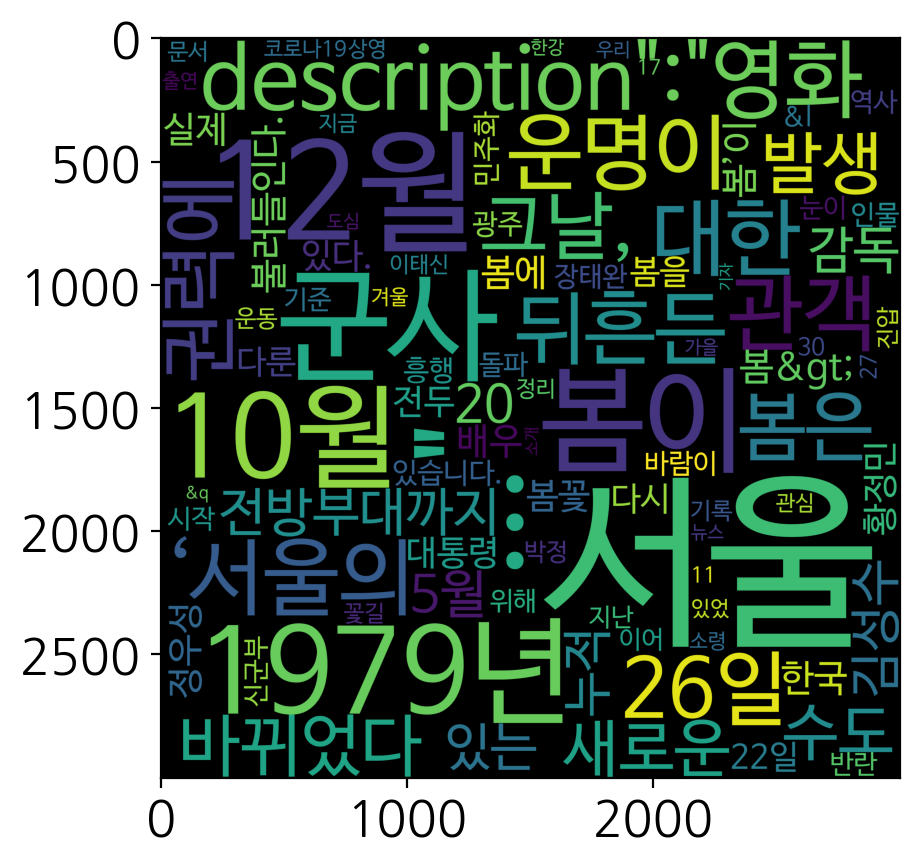

In [163]:
from wordcloud import WordCloud

wc = WordCloud(
    font_path = path,
    width=1000,  # 그래프 크기
    height=1000, # 그래프 크기
    scale=3.0, # 해상도 스케일링
    max_font_size=250 # 최대 폰트

)

gen = wc.generate_from_frequencies(passwords)

plt.figure()
plt.imshow(gen)

### 리뷰 크롤링

In [11]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time

headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36'}
encText = urllib.parse.quote("영화 서울의 봄 관람평")
url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query='+ encText

resp = requests.get(url, headers=headers)
# time.sleep(5)
soup = BeautifulSoup(resp.text, 'html.parser')

tag_list = soup.find_all('span', class_='desc _text')
review_list = [tag.get_text() for tag in tag_list]
review_list

['권력을 향한 탐욕과 상식적인 명분이 치열하게 맞부딪치던 밤의 이야기. 하나의 관점을 지닌 역사적 해석으로도, 상업적 감각과 재미를 겸한 창작물로서도 좋다. 영화를 통해 현대사의 암흑을 들여다보는 것은 일종의 각성제 역할을 한다. 민주주의의 봄을 겨울로 되돌리기 위해 또다시 어디에선가 벌어질지 모를 밀실 작당에 굴복하지 않기 위해서. ‘지금 같은 때에 어떻게 그런 일이 가능한가’라는 물음은 합당하지 않다. 44년 전에 이미 그런 식으로 봄은 한차례 끝이 났었다. 황정민과 정우성을 위시한 모든 배우들의 열연은 올스타전을 방불케 한다. 특히 황정민의 연기는 압도적 카리스마라 해야 할지, 마력에 가까운 그 무엇이라 해야 할지 망설여질 정도다. 그만큼 그가 연기한 전두광의 존재감은 뜨겁고 악랄한 불같다.',
 '12.12 군사 반란이라는 역사적 사실을 생생한 캐릭터와 상반된 가치의 충돌로 재구성했다. 육군 내 사조직 하나회의 우두머리 전두광(황정민)은 권력을 향한 야욕을 숨기지 않는다. 권력의 빈자리를 차지하기 위해 인맥, 협박, 뇌물 등 가용 자원을 모두 동원하다 국방에 쓰여야 하는 무력까지 사사로이 전횡한다. 탐욕을 채우기 위해 대의도 명분도 필요치 않은 그의 반대편에는 수도경비사령관 이태신(정우성)이 있다. 원칙대로 싸우겠다는 그는 부끄러움을 알고 신념을 가진 자다. 나라를 지킨다는 군인의 소명의식마저 내던진 전두광 패거리를 같은 군인으로서 수치스럽게 여긴 그의 싸움은 아무것도 담보하지 못했지만 그것이 정의이며 부끄러운 승리보다 값진 역사로 남았다.',
 '2023년 올해의 웰메이드 한국 영화다. 시나리오, 연출, 연기, 촬영, 편집, 음악, 미술, 사운드 등 영화를 이루는 모든 요소가 톱니바퀴처럼 맞물리며 일사불란하게 움직인다. 141분의 러닝타임이 짧게 느껴지는 이유다. 상업 영화의 재미를 충족하면서 근현대사를 다룬 팩션의 모범 사례를 만들었다. 안다고 생각했던 치욕의 역사를 돌이켜 저마다의 반응을 끌어내는 시도도 성공적이다. 분노일 수도, 반성일 수도, 

페이지 로딩 완료 후 크롤링

- https://copyprogramming.com/howto/python-request-wait-for-page-to-load#wait-page-to-load-before-getting-data-with-requestsget-in-python-3
- https://github.com/psf/requests-html/issues/440

In [71]:
from requests_html import HTMLSession, AsyncHTMLSession 

asession = AsyncHTMLSession() 
r = await asession.get(url)
await r.html.arender(sleep = 10) # sleeping is optional but do it just in case
html = r.html.raw_html
await asession.close()

soup = BeautifulSoup(html, 'html.parser')
tag_list = soup.find_all('span', class_='desc _text')
# tag_list = soup.select('span[class^="desc"]')

review_list = [tag.get_text() for tag in tag_list]
review_list

['팩트소재 영화지만 우성이형이 이기길 바라면서 본 사람들은 개추 ',
 '대통령 최규하는 참모총장 정승화, 수경사령관 장태완 체포동의서에 사인 후 12월13일이라는 날짜를 표기함. 이는 작전시작일인 12일보다 동의서 재가가 하루 늦었다는 것을 각인한 것으로, 작전과 재가 자체가 부당한 것이었음을 서류화한 것이다. 힘이 없...',
 '저 짓을 하고 늙어 죽었다는게 어이가 없다. ',
 '막을 수 있었기에 더 화가난다. ',
 '1979년 12월 12일..육사 출신들로 모여 만들어진 군내 사조직 하나회가 어떻게 반란을 했는지와 당시 육본 장군들의 비겁함과 무기력함..장태완 수경사령관과 정병주 특전사령관..그리고 반란군에 맞서 싸웠던 장병들의 헌신과 군인정신을 잘보았습니다.121...',
 '배우들 연기 미쳤다.. 몰입하다보니 영화 끝나있음.. 내 기준 올해 한국 영화 중에 탑ㅠ ',
 '알고는 있었지만 이 정도인 줄은 몰랐다. 물론 다큐가 아닌 영화라 상당 부분 각색되어 있지만 실제 사건의 흐름을 보고 앉아있자니 그라데이션으로 끓어오르는 빡침이 상당하다. 재미있는데 빡쳐. 언론 평가가 왜 이렇게 좋은지도 알겠고, 간만에 영화 같은 ...',
 '추악한 역사에서도 우리는 배운다 ',
 '영화 보다보면 전두광보다 국방부장관 더 후드려패고 싶지 않나요? ㅠㅠ ',
 '연기 미쳤다 진짜ㅠ 기대했던 것 보다 훨씬 더 잘만든 영화. 2시간 내내 몰입되서 시간이 어떻게 간 줄도 모르겠음. ',
 '팩트소재 영화지만 우성이형이 이기길 바라면서 본 사람들은 개추 ',
 '대통령 최규하는 참모총장 정승화, 수경사령관 장태완 체포동의서에 사인 후 12월13일이라는 날짜를 표기함. 이는 작전시작일인 12일보다 동의서 재가가 하루 늦었다는 것을 각인한 것으로, 작전과 재가 자체가 부당한 것이었음을 서류화한 것이다. 힘이 없는 시한부 대통령의 마지막 남은 자존심이었으리라. ',
 '저 짓을 하고 늙어 죽었다는게 어이가 없다. ',
 '막을 수 있었기에 더 화가난다. ',
 '1979년

### 네이버 통합 검색어 트랜드 조회
https://developers.naver.com/docs/serviceapi/datalab/search/search.md#%ED%86%B5%ED%95%A9-%EA%B2%80%EC%83%89%EC%96%B4-%ED%8A%B8%EB%A0%8C%EB%93%9C

In [14]:
#-*- coding: utf-8 -*-
url = "https://openapi.naver.com/v1/datalab/search";
body = '''
{
    \"startDate\":\"2023-11-01\",
    \"endDate\":\"2024-01-01\",
    \"timeUnit\":\"week\",
    \"keywordGroups\":[
        {
            \"groupName\":\"서울의 봄\",
            \"keywords\":[\"서울의 봄\",\"김성수\"]
        }
    ]
}
'''
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{"startDate":"2023-10-30","endDate":"2024-01-07","timeUnit":"week","results":[{"title":"서울의 봄","keywords":["서울의 봄","김성수"],"data":[{"period":"2023-10-30","ratio":3.26359},{"period":"2023-11-06","ratio":10.87866},{"period":"2023-11-13","ratio":12.38493},{"period":"2023-11-20","ratio":65.60669},{"period":"2023-11-27","ratio":93.43096},{"period":"2023-12-04","ratio":85.52301},{"period":"2023-12-11","ratio":100},{"period":"2023-12-18","ratio":95.1046},{"period":"2023-12-25","ratio":57.82426},{"period":"2024-01-01","ratio":28.03347}]}]}
